In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
%matplotlib inline
pd.options.display.precision = 3

In [17]:
# load responses-staph.csv - the result of antibiotic resistence of staphylococcus
# 125 * 1
resp = pd.read_csv('../data/responses-staph.csv')

In [18]:
# load core_gene_alignment-narsa.aln - the gene sequence of staphylococcus
# 125 * 983088
src = SeqIO.parse('../data/core_gene_alignment-narsa.aln', 'fasta')
data = [(record.id, record.seq._data.upper()) for record in src]
seq = pd.DataFrame(data=data, columns=['ids', 'sequence'])

In [19]:
# merge DataFrames of two files into one DataFrame
records = pd.merge(seq, resp, on='ids')

In [20]:
records['resp'].value_counts()

False    103
True      21
Name: resp, dtype: int64

In [21]:
# calculate missing number and percentage of nucleotides of each sequence
from collections import Counter

seq_len = np.mean(records['sequence'].apply(len))
records['missing'] = records['sequence'].apply(lambda seq: Counter(seq)['-'])

In [22]:
records['missing_percentage'] = records['missing'] / seq_len * 100
records

,ids,sequence,resp,missing,missing_percentage
0,NRS001,ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...,False,2511,0.255
1,NRS002,----------------------------------------------...,False,25278,2.571
2,NRS003,ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...,False,48213,4.904
3,NRS021,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,2442,0.248
4,NRS022,ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,3885,0.395
...,...,...,...,...,...
120,NRS272,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,66885,6.804
121,NRS275,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,8052,0.819
122,NRS383,ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,3003,0.305
123,NRS386,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,True,2790,0.284


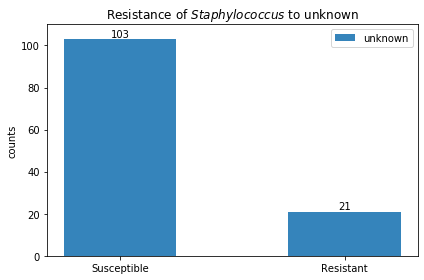

In [23]:
# show the skewness of the data set
def show_count(rects):
    '''Show the height of each bar in the bar chart'''
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     ha='center', va='bottom')

x = np.array([0, 0.5]) # False, True

resp_counts = records['resp'].value_counts()
rects = plt.bar(x=x, height=resp_counts, width=0.25, alpha=0.9, label='unknown')

show_count(rects)

plt.xticks(x, ['Susceptible', 'Resistant'])
plt.ylim((0, 110))
plt.ylabel('counts')
plt.title('Resistance of $Staphylococcus$ to unknown')

plt.tight_layout()
plt.legend()
plt.savefig('staph_skewness.png')
plt.show()

In [24]:
# calculate true/false percentage of the class
counts = pd.DataFrame({'unknown': resp_counts})
counts.div(counts.sum() / 100)

,unknown
False,83.065
True,16.935


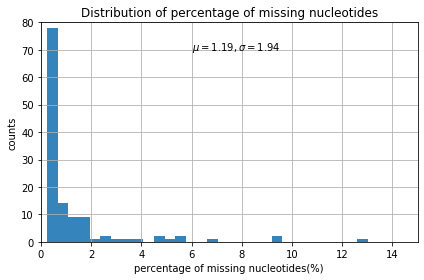

In [25]:
# show the missingness of the sequence
data = records['missing_percentage']
n, bins, patches = plt.hist(data, bins=30, alpha=0.9)
mu, sigma = np.mean(data), np.std(data)

plt.grid()
plt.xlim((0, 15))
plt.yticks(ticks=range(0, 90, 10))
plt.ylim((0, 80))
plt.ylabel('counts')
plt.xlabel('percentage of missing nucleotides(%)')
plt.title('Distribution of percentage of missing nucleotides')
plt.text(6, 70, '$\mu={:.3}, \sigma={:.3}$'.format(mu, sigma))

plt.tight_layout()
plt.savefig('staph_missingness_1.png')
plt.show()

In [26]:
highest_missing_percentage = np.max(records['missing_percentage'])
highest_missing_percentage

13.025792197646599

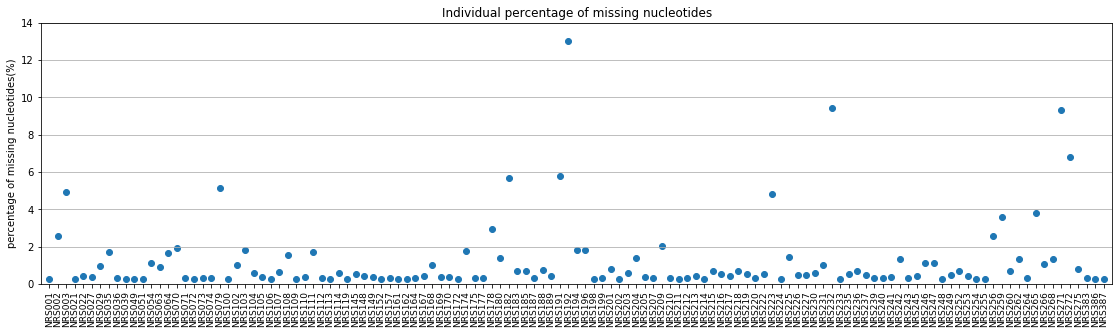

In [27]:
# show the individual missingness of the sequence
plt.figure(figsize=(19.2, 4.8))
plt.scatter(range(125), records['missing_percentage'])

plt.xlim((-1, 125))
plt.ylim((0, 14))
plt.xticks(ticks=range(125), labels=records['ids'].to_list(), rotation=90, fontsize=9)
plt.ylabel('percentage of missing nucleotides(%)')
plt.title('Individual percentage of missing nucleotides')
plt.grid(axis='y')
plt.savefig('staph_missingness_2.png')
plt.show()

# Experiment

In [28]:
sequence = records['sequence']
sequence

0      ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...
1      ----------------------------------------------...
2      ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...
3      ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
4      ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
                             ...                        
120    ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
121    ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
122    ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
123    ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
124    ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...
Name: sequence, Length: 125, dtype: object

In [29]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

In [30]:
forward = str.maketrans('-ACTGN', '012345')
backward = str.maketrans('012345', '-ACTGN')
def transformation(str):
    return [int(i) for i in str.translate(forward)]

In [31]:
from collections import Counter

for seq in sequence:
    print(Counter(seq))

Counter({'A': 345986, 'T': 294496, 'G': 192941, 'C': 147154, '-': 2511})
Counter({'A': 337511, 'T': 287275, 'G': 189106, 'C': 143918, '-': 25278})
Counter({'A': 329401, 'T': 279828, 'G': 184938, 'C': 140708, '-': 48213})
Counter({'A': 345979, 'T': 294475, 'G': 192959, 'C': 147233, '-': 2442})
Counter({'A': 345511, 'T': 294082, 'G': 192719, 'C': 146891, '-': 3885})
Counter({'A': 345660, 'T': 294132, 'G': 192816, 'C': 147105, '-': 3375})
Counter({'A': 343519, 'T': 292212, 'G': 191690, 'C': 146262, '-': 9405})
Counter({'A': 340683, 'T': 289818, 'G': 190408, 'C': 145157, '-': 17022})
Counter({'A': 345863, 'T': 294299, 'G': 192890, 'C': 147153, '-': 2883})
Counter({'A': 346022, 'T': 294459, 'G': 192979, 'C': 147225, '-': 2403})
Counter({'A': 345896, 'T': 294441, 'G': 192901, 'C': 147120, '-': 2730})
Counter({'A': 346018, 'T': 294491, 'G': 192954, 'C': 147156, '-': 2469})
Counter({'A': 343034, 'T': 291567, 'G': 191407, 'C': 146010, '-': 11070})
Counter({'A': 343732, 'T': 292542, 'G': 191825,

Counter({'A': 333750, 'T': 284428, 'G': 187020, 'C': 142535, '-': 35355})
Counter({'A': 344507, 'T': 293082, 'G': 192302, 'C': 146690, '-': 6507})
Counter({'A': 342320, 'T': 291156, 'G': 190768, 'C': 145533, '-': 13311})
Counter({'A': 345827, 'T': 294283, 'G': 192884, 'C': 147118, '-': 2976})
Counter({'A': 333404, 'T': 283573, 'G': 186756, 'C': 142239, '-': 37116})
Counter({'A': 342969, 'T': 292209, 'G': 191551, 'C': 146018, '-': 10341})
Counter({'A': 341953, 'T': 291024, 'G': 191209, 'C': 145765, '-': 13137})
Counter({'A': 313368, 'T': 266590, 'G': 176748, 'C': 134675, '-': 91707})
Counter({'A': 322138, 'T': 274214, 'G': 181594, 'C': 138257, '-': 66885})
Counter({'A': 343824, 'T': 292775, 'G': 192026, 'C': 146411, '-': 8052})
Counter({'A': 345856, 'T': 294253, 'G': 192840, 'C': 147136, '-': 3003})
Counter({'A': 345875, 'T': 294369, 'G': 192915, 'C': 147139, '-': 2790})
Counter({'A': 346018, 'T': 294490, 'G': 192942, 'C': 147151, '-': 2487})


In [32]:
%time tran = selector.fit_transform(sequence.apply(transformation).to_list())

CPU times: user 46.7 s, sys: 936 ms, total: 47.7 s
Wall time: 47.7 s


In [33]:
len(tran[0])

496218